# About : 

**This notebook tries to classify between benign and malignant skin growths**

 Common skin growths can be:

    Malignant: A cancerous growth that can spread very quickly and invade nearby tissues
    Benign: A non-cancerous growth that usually grows very slowly and does not spread to other areas

When a healthcare provider is consulted regarding a skin growth, the first step in the diagnostic procedure is a physical examination. The diagnostician must examine the skin closely to determine whether the growth is benign or if it has the potential to be malignant.

If a growth appears to have the potential to be malignant, a tissue sample must be sent to the lab and a biopsy must be performed. A biopsy involves looking under a microscope to determine if cancerous cells are present in a tissue sample.  

src: https://www.verywellhealth.com/common-skin-growths-5119764

**What is Benign Tumor** 

Benign tumors are noncancerous growths in the body. Unlike cancerous tumors, they don’t spread (metastasize) to other parts of the body.

Benign tumors can form anywhere. If you discover a lump or mass in your body that can be felt from the outside, you might immediately assume it is cancerous. For instance, women who find lumps in their breasts during self-examinations are often alarmed. However, most breast growths are benign. In fact, many growths throughout the body are benign.

The exact cause of a benign tumor is often unknown. It develops when cells in the body divide and grow at an excessive rate. Typically, the body is able to balance cell growth and division. When old or damaged cells die, they are automatically replaced with new, healthy cells. In the case of tumors, dead cells remain and form a growth known as a tumor.

src: https://www.healthline.com/health/benign




# Malignant Tumors: 

Malignant tumor is a tumor that is invasive, meaning it can invade the surrounding tissues. Malignant tumors contain cells that are cancerous, growing out of control and capable of metastasizing. Metastasize simply means that the cells of the tumor are able to leave the original tumor and travel to other parts of the body.

In cancerous tumors or malignant tumors, the cells have lost the ability to stop growing. In other words, they have gone rogue and will not stop dividing. To better explain, nearly every cell in the body is able to grow and divide to make new cells, to a certain extent. This is important for all living organisms. When cells go rogue, however, there is a problem with the DNA. When mutations, which are changes in the DNA sequence, occur, they cause the cells to forget how to stop dividing. After some time, the mass of cells becomes a tumor. 

src: https://study.com/academy/lesson/what-is-a-malignant-tumor-definition-treatment.html

# Imports 

In [1]:
#general 
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib import  cm
import cv2
import random
from IPython import display



#metrics 
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,precision_score,recall_score


#data loading 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#deep learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dropout,Dense,MaxPooling2D,GaussianNoise,Flatten,Input,BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical

#backend
from tensorflow.keras import backend as K

#filter warnings
import warnings 
warnings.filterwarnings('ignore')

# Config

In [2]:
seed=7
img_size = (224,224)
batch_size=64



def set_seed(seed):
    
    '''set seed for reproducablity'''
    os.environ['PYTHONHASHSEED']= str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(seed)    

# Input Data 

In [3]:
train_dir  = '../input/skin-cancer-malignant-vs-benign/train/'
test_dir ='../input/skin-cancer-malignant-vs-benign/test/'


In [4]:
train_gen = ImageDataGenerator(    
#     width_shift_range=(0.05,0.05), # (-width_shift_range, +width_shift_range)
#     height_shift_range=(0.05,0.05),
#     brightness_range=(0.8,1.2),
#     shear_range=1.2,
#     samplewise_std_normalization=False, # Divide each input by its std
    zca_whitening=False,  # A whitening transform of an image is a linear algebra operation that reduces the redundancy in the matrix of pixel images.
#     zca_epsilon=1e-06,   
    rotation_range=180,    # degree range for randm rot
    zoom_range=(0.8,1.2),
#     channel_shift_range=0.05,
#     fill_mode='nearest',
#     cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255,
    validation_split = 0.15)

test_gen = ImageDataGenerator(rescale=1/255)




#train data 
train_data = train_gen.flow_from_directory(train_dir,
                                           target_size=img_size,
                                           class_mode='binary',
                                           batch_size=batch_size,
                                           seed=seed,
                                          subset='training',
                                          shuffle=True)


#validation data 
val_data = train_gen.flow_from_directory(train_dir,
                                           target_size=img_size,
                                           class_mode='binary',
                                           batch_size=batch_size,
                                           seed=seed,
                                          subset='validation',
                                          shuffle=True)


test_data = test_gen.flow_from_directory(test_dir,
                                       target_size=img_size,
                                       class_mode='binary',
                                       batch_size=batch_size,
                                       seed=seed,
                                       shuffle=True)


class_dict = {str(v):k for k,v in train_data.class_indices.items()}

Found 2242 images belonging to 2 classes.
Found 395 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


# Helper Functions

In [5]:
def plot_image_grid(image_list,
                    label_list,
                    sample_images=False,
                    num_images=12,
                    pre_title='class',
                    num_img_per_row=3,
                    cmap=None,
                    img_h_w=5):
    '''viz images from a list of images and labels
    INPUTS:
    image_list: a list of images to be plotted,
    label_list: a list of correspomding image labels'''
    


    #number of img rows
    n_row= num_images//num_img_per_row

    plt.subplots(n_row,num_img_per_row,figsize=(img_h_w*num_img_per_row,img_h_w*n_row))

    if sample_images:
    #select_random images 
        sampled_ids = random.choices(np.arange(0,len(image_list)),k=num_images)

        for i,idx in enumerate(sampled_ids):

            img = image_list[idx]
            label = label_list[i]
            plt.subplot(n_row,num_img_per_row,i+1)
            plt.title(f'{pre_title} - {label}')
            plt.axis('off')
            plt.imshow(img,cmap=cmap)
    else:
        for i,img in enumerate(image_list):

            label = label_list[i]
            plt.subplot(n_row,num_img_per_row,i+1)
            plt.title(f'{pre_title} - {label}')
            plt.axis('off')
            plt.imshow(img,cmap=cmap)

            # break the loop 
            if i==num_images-1 :
                  break 

    #show
    plt.tight_layout()
    plt.show()
    
    
    

In [6]:
# import pdb
class custom_cnn:
    def __init__(self):

        # layer regularization
        self.layer_reg ={'kernel_reg':{'l1':1e-5,
                                       'l2':1e-4},
                       'bias_reg': {'l1':1e-5,
                                   'l2':1e-4}
                        }


        # params for building model
        self.params = {
                  'n_dense' : [16],             # number of dense layer after conv
                  'dense_act': ['relu','relu'],     # dnese layer activation
                  'layer_reg': self.layer_reg,           # layer regularization params
                  'drop'    :[0.6,0.5],             # dropout rates 
                  'kernel_size':[(3,3),(3,3),(3,3)],      # kernel sizes
                  'pool_size' : [(2,2),(2,2),(2,2)],      # pooling size
                  'conv'    : [8,16,32],             # conv layer number of filters * 2
                  'strides' : [1,1,1],
                  'activations': ['relu','relu','relu'],   # conv layer activations 
                  'batch_norm': True,
                  'gaussian_noise':True,
                  'Gaussian_noise_std':0.1
                 }
        
    
    
    def build(self,
              input_shape,
              update_params,
              output_layer
             ):
        self.input_shape=input_shape
        
        self.output_params = output_layer
        #update params shape
        if update_params:
            self.params.update(update_params)
        '''
        build a CNN with given parameters
        -input_shape   :  input image shape (example: (256,256,3),
        - update_params: update build params
        - output_layer : output_layer_params , ex {'n_out':num_classes,'activation':'softmax'}
        
        
        # Build Params:
        
        n_dense : list of number of units in each dense layer
        activations: list of activation in each CONV layer  
        kernel_size:list of kernel size
        conv: list of number of conv filters
        pool_size: list of pooling size 
        layer_reg: dense layer regularization
        drop     : list of dropouts after dense layers
        compile_params: model compilation parameters ,
        gaussian_noise: add gaussian noise layer to the model with std of given value'''
           
        # input layer
        inp = Input(shape = self.input_shape)
        if self.params['gaussian_noise']:
          #add gaussian noise
            x = GaussianNoise(stddev=self.params['Gaussian_noise_std'])(inp)
            
            x = Conv2D(self.params['conv'][0],
                   activation=self.params['activations'][0],
                   kernel_size=self.params['kernel_size'][0],
                   strides =self.params['strides'][0])(x)
        
        else:
        
            x = Conv2D(self.params['conv'][0],
                   activation=self.params['activations'][0],
                   kernel_size=self.params['kernel_size'][0],
                   strides =self.params['strides'][0])(inp)
        
        x = Conv2D(self.params['conv'][0],
                   activation=self.params['activations'][0],
                   kernel_size=self.params['kernel_size'][0],
                   strides =self.params['strides'][0])(x)
        x = MaxPooling2D(pool_size=self.params['pool_size'][0],
                         strides =self.params['strides'][0])(x)
        
        if self.params['batch_norm']:
            x = BatchNormalization()(x)

        for i in range(1,len(self.params['conv'])):
            x = Conv2D(self.params['conv'][i],
                       activation =self.params['activations'][i],
                       kernel_size=self.params['kernel_size'][i],
                       strides =self.params['strides'][i])(x)
            x = Conv2D(self.params['conv'][i],
                       activation =self.params['activations'][i],
                       kernel_size=self.params['kernel_size'][i],
                      strides =self.params['strides'][i])(x)
            x = MaxPooling2D(pool_size=self.params['pool_size'][i],
                             strides =self.params['strides'][i])(x)
            
            if self.params['batch_norm']:
                x = BatchNormalization()(x)

        # 
        x = Flatten()(x)
        
        
#         pdb.set_trace()
        # regularization
        self.kernel_reg=regularizers.l1_l2(l1=self.params['layer_reg']['kernel_reg']['l1'],
                                           l2=self.params['layer_reg']['kernel_reg']['l2'])

        x = Dense(self.params['n_dense'][0],
                  activation=self.params['dense_act'][0],
                  kernel_regularizer=self.kernel_reg,
                  bias_regularizer = regularizers.l1_l2(
                      l1=self.params['layer_reg']['bias_reg']['l1'],
                      l2=self.params['layer_reg']['bias_reg']['l2']))(x)

        x = BatchNormalization()(x)
        x = Dropout(self.params['drop'][0])(x)

        if len(self.params['n_dense'])>1:
            for i in range(1,len(self.params['n_dense'])):
                x = Dense(self.params['n_dense'][i],
                          activation=self.params['dense_act'][i],
                          kernel_regularizer=self.kernel_reg,
                          bias_regularizer = regularizers.l1_l2(l1=self.params['layer_reg']['bias_reg']['l1'],
                                                                l2=self.params['layer_reg']['bias_reg']['l2']))(x)
                #drop
                x = BatchNormalization()(x)
                x = Dropout(self.params['drop'][i])(x)

        out = Dense(self.output_params['n_out'],
                    activation=self.output_params['activation'])(x)
        
        
        model = Model(inputs=[inp],outputs = out)
        return model 
    
# plot train and val acc as  a function of epochs
def plot_history(history,addn_metric=None):
    '''
    Inputs
    history:history object from tensorflow
    add_metric: metric name in the history (like f1_score)'''
    his=pd.DataFrame(history.history)
    
    if addn_metric:
        plt.subplots(1,3,figsize=(20,6))
        
        #loss:
        ax1=plt.subplot(1,3,1)
        ax1.plot(range(len(his)),his['loss'],color='g',label='training')
        ax1.plot(range(len(his)),his['val_loss'],color='r',label='validation')
        ax1.set_xlabel('EPOCHS')
        ax1.set_ylabel('LOSS')
        ax1.legend()
        ax1.set_title('Loss Per Epoch')

        #accuracy
        ax2=plt.subplot(1,3,2)
        ax2.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
        ax2.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')
        ax2.set_xlabel('EPOCHS')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_title('Accuracy Per Epoch')

    
        
        ax3= plt.subplot(1,3,3)
        ax3.plot(range(len(his)),his[f'{addn_metric}'],color='g',label='training')
        ax3.plot(range(len(his)),his[f'val_{addn_metric}'],color='r',label='validation')
        ax3.set_xlabel('EPOCHS')
        ax3.set_ylabel(f'{addn_metric}')
        ax3.legend()
        ax3.set_title(f'{addn_metric} Per Epoch')

        
    else:
        plt.subplots(1,2,figsize=(20,8))
        
    
    
        #loss:
        ax1=plt.subplot(1,2,1)
        ax1.plot(range(len(his)),his['loss'],color='g',label='training')
        ax1.plot(range(len(his)),his['val_loss'],color='r',label='validation')
        ax1.set_xlabel('EPOCHS')
        ax1.set_ylabel('LOSS')
        ax1.legend()
        ax1.set_title('Loss Per Epoch')

        #accuracy
        ax2=plt.subplot(1,2,2)
        ax2.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
        ax2.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')
        ax2.set_xlabel('EPOCHS')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_title('Accuracy Per Epoch')

        
    
    
    plt.show()  

# Checking some images 

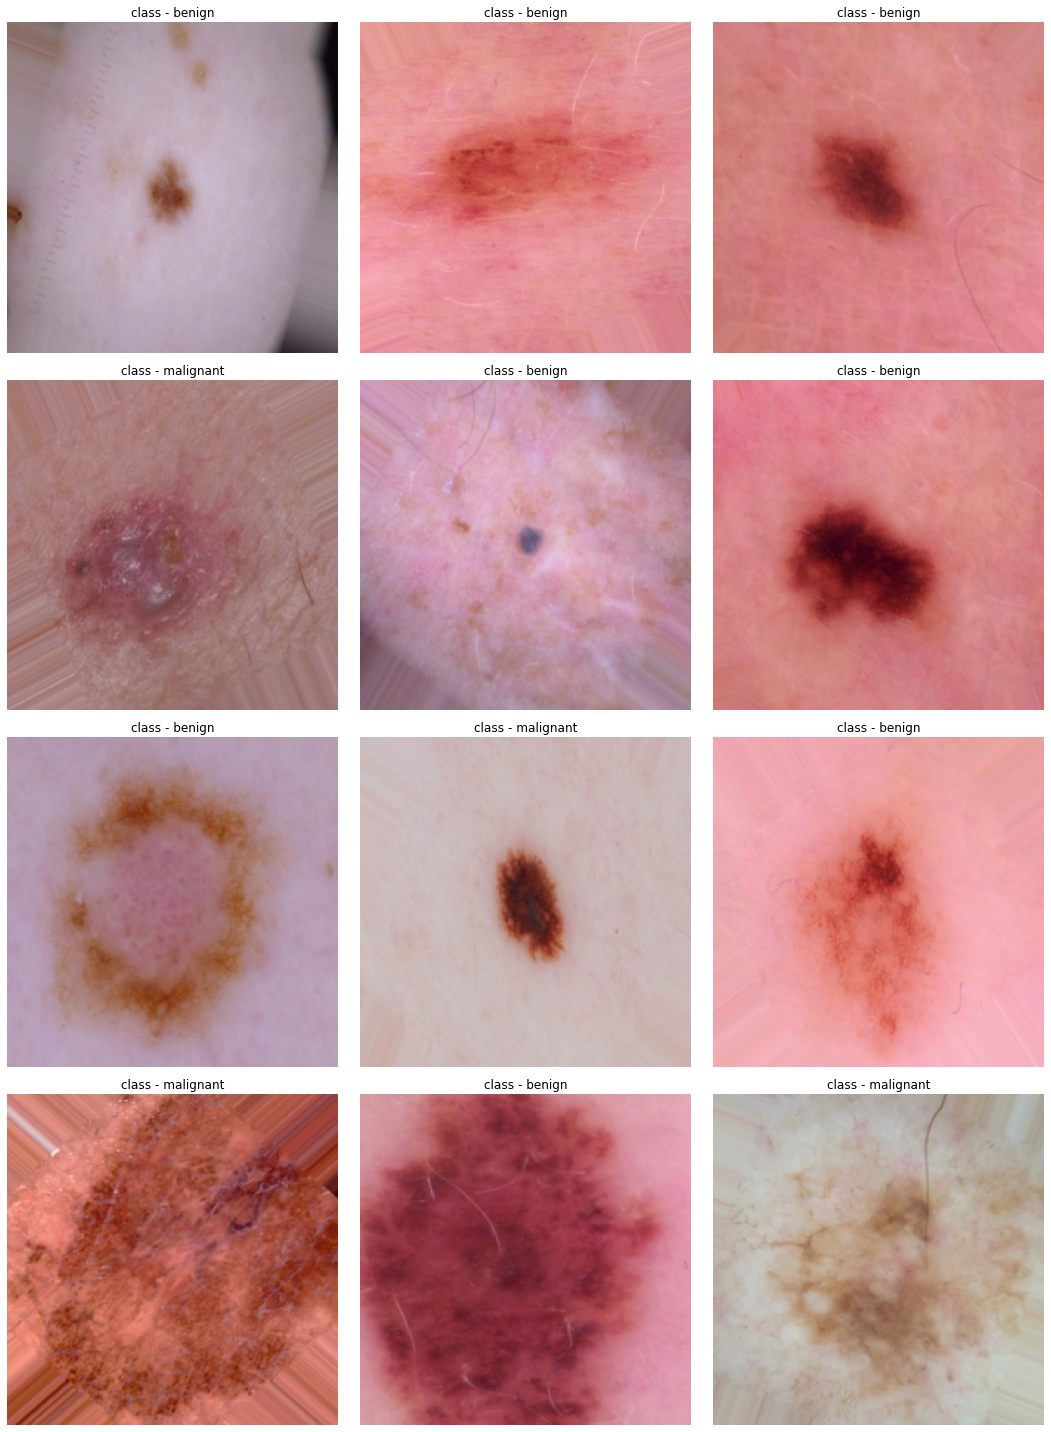

In [7]:
imgs,lab = train_data.next()

labels = [class_dict[str(int(i))] for i in lab]


plot_image_grid(image_list=imgs,label_list =labels,num_images=12)

**Metrics**

In [8]:

#from https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Building Model

In [12]:


layer_reg ={'kernel_reg':{'l1':1e-7,'l2':1e-6},
            'bias_reg': {'l1':1e-7,
                         'l2':1e-6}}

params = {
                  'n_dense' : [16],             # number of dense layer after conv
                  'dense_act': ['relu','relu'],     # dnese layer activation
                  'layer_reg': layer_reg,           # layer regularization params
                  'drop'    :[0.5,0.5],             # dropout rates after dense
                  'kernel_size':[(3,3),(3,3),(3,3)],      # kernel sizes
                  'pool_size' : [(2,2),(2,2),(2,2)],      # pooling size
                  'conv'    : [16,32,64],             # conv layer number of filters * 2
                  'strides' : [2,1,1],
                  'activations': ['relu','relu','relu'],   # conv layer activations 
                  'batch_norm': True,
                  'gaussian_noise':True,
                  'Gaussian_noise_std':0.1  # gaussian noise std dev
                 }

cnn_model = custom_cnn().build(input_shape=(img_size+ (3,)),
                               update_params=params,  # model parameters
                               output_layer={'n_out':1, # output dense layer
                                            'activation':'sigmoid'})


# # compilation params
compile_params ={'loss':'binary_crossentropy',
                'metrics':['accuracy',f1_score,recall_m,precision_m],
                'optimizer':'adam'}

cnn_model.compile(**compile_params)

cnn_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 111, 111, 16)      448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 55, 55, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 27, 27, 16)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 27, 27, 16)        64        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 25, 25, 32)        4640

# Fitting Model

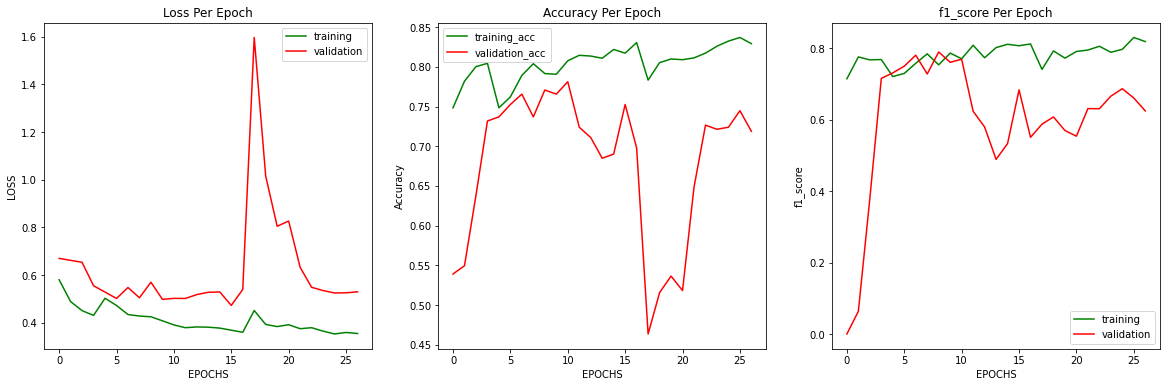

In [13]:
# callbacks 
#reduce_lr
reduce_lr=ReduceLROnPlateau(patience=2,
                            factor=0.8,
                            min_delta=1e-2,
                            monitor='val_f1_score',
                            verbose=1,
                            mode='max')

#early stopping
early_stopping=EarlyStopping(patience=20,
                             min_delta=1e-2,
                              monitor='val_f1_score',
                              restore_best_weights=True,
                              mode='max')

EPOCHS = 100

history = cnn_model.fit(train_data,
                        validation_data = val_data,
                        steps_per_epoch=train_data.n//batch_size,
                        validation_steps = val_data.n//batch_size,
                       epochs=EPOCHS,
                       callbacks = [reduce_lr,early_stopping],
                       verbose=1)

display.clear_output()

plot_history(history,'f1_score')

In [14]:
#saving model

models = 'saved_models'
if not os.path.exists('./'+ models):
    os.mkdir(models)
cnn_model.save(filepath=os.path.join(models,'cnn_skin_cn.h5'))

# Evaluating Model

In [15]:
_=cnn_model.evaluate(val_data)

7/7 [==============================] - 5s 757ms/step - loss: 0.5421 - accuracy: 0.7696 - f1_score: 0.7621 - recall_m: 0.9016 - precision_m: 0.6698


In [16]:
_=cnn_model.evaluate(test_data)

11/11 [==============================] - 5s 501ms/step - loss: 0.5335 - accuracy: 0.7727 - f1_score: 0.7983 - recall_m: 0.9746 - precision_m: 0.6790


# Get prediction on test set 

In [17]:
#thresholding 
def roc_threshold(y_true,y_pred):
    '''get best threshold from a roc_auc_curve
    y_true: ground truth
    y_pred: predicted probabilities'''


    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    thresh_tpr=tpr[ix]
    thresh_fpr=fpr[ix]
    print(f'Best Threshold (TPR-FPR)= {best_thresh} \n TPR :{thresh_tpr} \n FPR :{thresh_fpr}')

    #best threshold by geometric mean :
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))

    # locate the index of the largest g-mean
    ix1 = np.argmax(gmeans)
    
    
    print('Best Threshold (geometric mean) = %f \n G-Mean=%.3f' % (thresholds[ix1], gmeans[ix1]))

    return best_thresh

# Visualizing model predictions

In [34]:
!pip install tf_keras_vis -q

In [35]:
import tf_keras_vis 

tf_keras_vis.__version__

'0.8.0'

In [36]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus



In [37]:
#gradcam algo : https://keras.io/examples/vision/grad_cam/


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [38]:
# src: https://pypi.org/project/tf-keras-vis/

def model_modifier_function(cloned_model):
    '''modify model activation'''
    cloned_model.layers[-1].activation = tf.keras.activations.linear

    
def get_saliency(img,
                 score,
                 cnn_model=cnn_model,
                 model_modifier=model_modifier_function):
    #saliency map
    

    # Create Saliency object.
    saliency = Saliency(cnn_model,
                        model_modifier=model_modifier_function,
                        clone=True)
    #saliency map 
    sal_map  = saliency(score,
                        np.array(img),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
    return sal_map

def get_gradcam(img,
                score,
                cnn_model=cnn_model,
                model_modifier=model_modifier_function):

    # Create Gradcam object
    gradcam = Gradcam(cnn_model,
                      model_modifier,
                      clone=True)

    # Generate heatmap with GradCAM
    cam = gradcam(score,
                  img,
                  seek_penultimate_conv_layer=True)
    
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    
    
    return heatmap

def get_gradcam_plus(img,
                    score,
                    model=cnn_model,
                    model_modifier=ReplaceToLinear()):
    
    # Create GradCAM++ object
    gradcam = GradcamPlusPlus(model,
                          model_modifier=model_modifier,
                          clone=True)
    
    cam = gradcam(score,
                  img)
    
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    
    return heatmap

**Visualizing Test predictions**

In [39]:
#get a batch of test data 
imgs,labs = test_data.next()

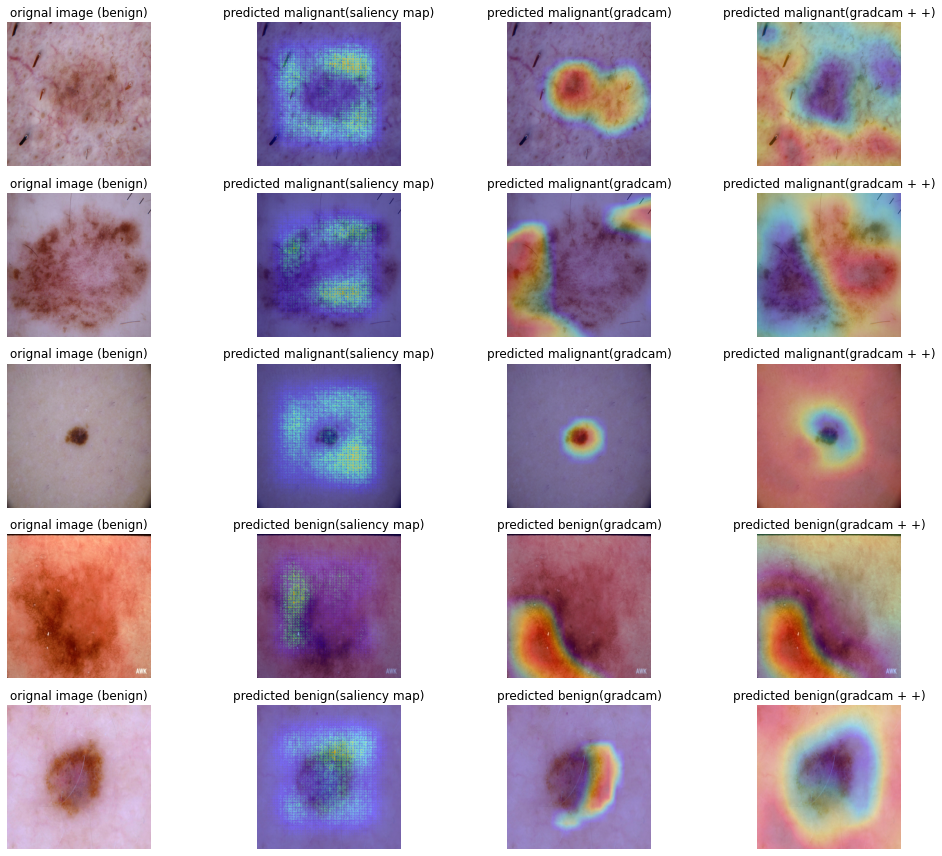

In [76]:
plt.subplots(5,4,figsize=(5*3,4*3))

idx=1

for i,img in enumerate(imgs[:5]):
    lab = np.argmax(labs[i])
    score1 = CategoricalScore([lab])
    
     
    #predict on image
    prd= str(int(cnn_model.predict(img.reshape(1,224,224,3))>0.75))
    
    plt.subplot(5,4,idx)
    plt.title(f'orignal image ({class_dict[str(lab)]})')
    plt.axis('off')
    plt.imshow(img)
    idx+=1
    
    #saliency
    plt.subplot(5,4,idx)
    plt.title(f'predicted {class_dict[prd]}(saliency map)')
    sal = get_saliency(img,
                       score1).reshape(224,224,1)
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(sal,alpha=0.45,cmap='jet') #overlay
    idx+=1
    
    #gradcam
    plt.subplot(5,4,idx)
    gdcam = get_gradcam(img,
                        score1)
    plt.imshow(img)
    plt.imshow(gdcam,alpha=0.30,cmap='jet') #overlay
    plt.title(f'predicted {class_dict[prd]}(gradcam)')
    plt.axis('off')
    idx+=1
    
    
    #gradcam ++
    plt.subplot(5,4,idx)
    gdcam_pls = get_gradcam_plus(img,
                                 score1)
    plt.imshow(img)
    plt.imshow(gdcam_pls,alpha=0.30,cmap='jet') #overlay
    plt.title(f'predicted {class_dict[prd]}(gradcam + +)')
    plt.axis('off')
    idx+=1
    
    if idx>20:
        break

plt.tight_layout()
plt.show()

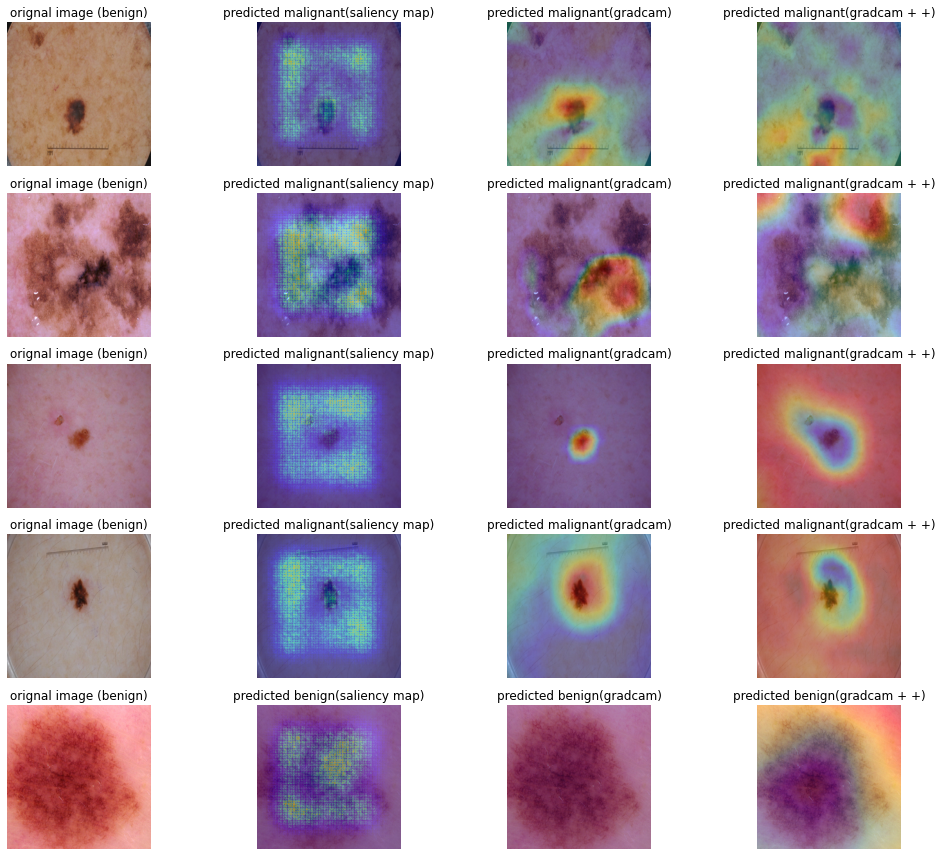

In [77]:
plt.subplots(5,4,figsize=(5*3,4*3))

idx=1

for i,img in enumerate(imgs[5:10]):
    i=i+5
    lab = np.argmax(labs[i])
    score1 = CategoricalScore([lab])
    
    #predict on image
    prd= str(int(cnn_model.predict(img.reshape(1,224,224,3))>0.75))
    
    plt.subplot(5,4,idx)
    plt.title(f'orignal image ({class_dict[str(lab)]})')
    plt.axis('off')
    plt.imshow(img)
    idx+=1
    
    #saliency
    plt.subplot(5,4,idx)
    plt.title(f'predicted {class_dict[prd]}(saliency map)')
    sal = get_saliency(img,
                       score1).reshape(224,224,1)
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(sal,alpha=0.45,cmap='jet') #overlay
    idx+=1
    
    #gradcam
    plt.subplot(5,4,idx)
    gdcam = get_gradcam(img,
                        score1)
    plt.imshow(img)
    plt.imshow(gdcam,alpha=0.30,cmap='jet') #overlay
    plt.title(f'predicted {class_dict[prd]}(gradcam)')
    plt.axis('off')
    idx+=1
    
    
    #gradcam ++
    plt.subplot(5,4,idx)
    gdcam_pls = get_gradcam_plus(img,
                                 score1)
    plt.imshow(img)
    plt.imshow(gdcam_pls,alpha=0.30,cmap='jet') #overlay
    plt.title(f'predicted {class_dict[prd]}(gradcam + +)')
    plt.axis('off')
    idx+=1
    
    if idx>20:
        break

plt.tight_layout()
plt.show()

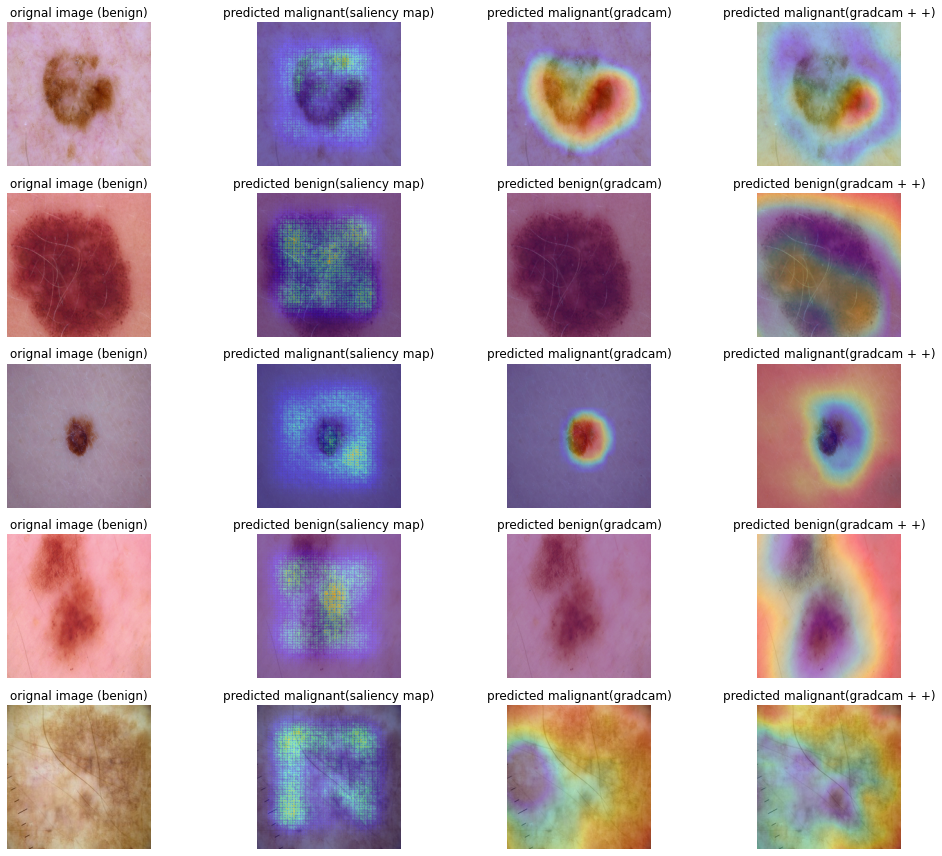

In [78]:
plt.subplots(5,4,figsize=(5*3,4*3))

idx=1

for i,img in enumerate(imgs[10:15]):
    i=i+10
    lab = np.argmax(labs[i])
    score1 = CategoricalScore([lab])
    
    #predict on image
    prd= str(int(cnn_model.predict(img.reshape(1,224,224,3))>0.75))
    
    plt.subplot(5,4,idx)
    plt.title(f'orignal image ({class_dict[str(lab)]})')
    plt.axis('off')
    plt.imshow(img)
    idx+=1
    
    #saliency
    plt.subplot(5,4,idx)
    plt.title(f'predicted {class_dict[prd]}(saliency map)')
    sal = get_saliency(img,
                       score1).reshape(224,224,1)
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(sal,alpha=0.45,cmap='jet') #overlay
    idx+=1
    
    #gradcam
    plt.subplot(5,4,idx)
    gdcam = get_gradcam(img,
                        score1)
    plt.imshow(img)
    plt.imshow(gdcam,alpha=0.30,cmap='jet') #overlay
    plt.title(f'predicted {class_dict[prd]}(gradcam)')
    plt.axis('off')
    idx+=1
    
    
    #gradcam ++
    plt.subplot(5,4,idx)
    gdcam_pls = get_gradcam_plus(img,
                                 score1)
    plt.imshow(img)
    plt.imshow(gdcam_pls,alpha=0.30,cmap='jet') #overlay
    plt.title(f'predicted {class_dict[prd]}(gradcam + +)')
    plt.axis('off')
    idx+=1
    
    if idx>20:
        break

plt.tight_layout()
plt.show()

# **Making a predictor**

In [67]:
class skin_cancer_detector:
    def __init__(self,
                model = cnn_model,
                class_dict= class_dict,
                img_size = (1,224,224,3),
                threshold=0.65):
        self.model = model
        self.classes = class_dict
        self.img_size= img_size
        self.threshold = threshold
        
    def load_image(self,
                   image_path):
        
        img= cv2.imread(image_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = img.reshape(self.img_size)
        
        return img
    
    def predict(self,image_path,show_image=True):
        
        self.loaded_img = self.load_image(image_path)
        
        self.pred = self.model.predict(self.loaded_img)
        print(self.pred)
        
        self.prediction = self.classes[str(int(self.pred>self.threshold))]
        if self.pred< self.threshold:
            self.pred = 1- self.pred
                    
        prob = str(self.pred)
        if show_image:
            plt.figure(figsize=(7,7))
            plt.title(f'prediction {self.prediction} (probablity={prob})')
            plt.imshow(self.loaded_img[0])
            plt.axis('off')
            plt.show()
            
        return self.prediction

In [68]:
#initiate predictor 
predictor = skin_cancer_detector()

[[0.]]


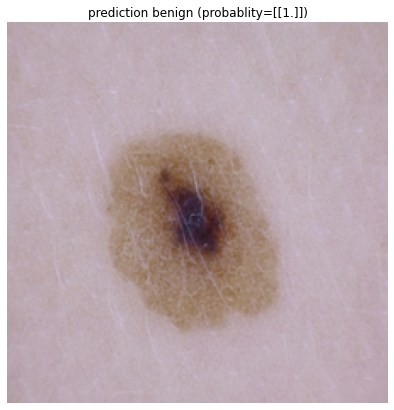

CPU times: user 370 ms, sys: 84 ms, total: 454 ms
Wall time: 335 ms


In [69]:
%%time
#predict
_=predictor.predict('../input/skin-cancer-malignant-vs-benign/test/benign/1033.jpg')